# Getting sequence from aligned data

## Preparing the data

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
# Load
data = np.load('../data/aligned/all/20231021_190000h.npy')

print(data.shape)  # Display the dimensions of the array
print(data.dtype)  # Display the data type of the array

# Process
data_mean = np.mean(data)
data_mean

df = pd.DataFrame(data)
df.head()


(128, 652848)
float32


,0,1,2,3,4,5,6,7,8,9,...,652838,652839,652840,652841,652842,652843,652844,652845,652846,652847
0,0.002872,0.002587,0.001776,0.000865,0.000249,0.000030,0.000027,0.000121,0.000483,0.001240,...,0.000284,0.000535,0.000634,0.000541,0.000547,0.000890,0.001437,0.001780,0.001667,0.001283
1,0.003674,0.003148,0.001856,0.000651,0.000081,0.000039,0.000084,0.000016,0.000162,0.000943,...,0.000914,0.000986,0.001150,0.001355,0.001365,0.001230,0.001195,0.001360,0.001602,0.001504
2,0.003323,0.002998,0.002158,0.001244,0.000612,0.000294,0.000232,0.000377,0.000765,0.001475,...,0.000055,0.000569,0.001112,0.001086,0.000674,0.000324,0.000334,0.000637,0.000792,0.000674
3,0.003231,0.002706,0.001576,0.000563,0.000167,0.000305,0.000524,0.000561,0.000459,0.000459,...,0.000465,0.000881,0.001410,0.001818,0.001918,0.001656,0.001186,0.000731,0.000406,0.000201
4,0.003638,0.003317,0.002251,0.001153,0.000602,0.000634,0.000745,0.000644,0.000360,0.000148,...,0.000582,0.000921,0.001378,0.001936,0.002352,0.002340,0.001863,0.001148,0.000541,0.000199


## Divide into lin and co

In [3]:
def divide_into_lin_co(datapath : str, linpath : str = None, copath : str = None) -> tuple:
    """
    Divide .npy files in a directory into two parts and save them in separate directories.
    
    Parameters:
    - datapath (str): Path to the directory containing .npy files.
    - linpath (str, optional): Path to the directory where the second part of the data will be saved. 
                                If not provided, a 'lin' directory will be created inside datapath.
    - copath (str, optional): Path to the directory where the first part of the data will be saved. 
                                If not provided, a 'co' directory will be created inside datapath.
    
    Returns:
    - tuple: A tuple containing the paths to the 'lin' and 'co' directories.
    
    The function performs the following steps:
    1. Lists all .npy files in the specified datapath.
    2. Creates 'lin' and 'co' directories if they do not exist.
    3. For each .npy file, loads the data, divides it into two parts:
        - The first 60 rows are saved in the 'co' directory.
        - The remaining rows are saved in the 'lin' directory.
    """
    
    # Obtén la lista de archivos .npy en el directorio
    files = [f for f in os.listdir(datapath) if f.endswith('.npy')]

    if linpath is not None:
        # Crea el directorio 'lin' si no existe
        os.makedirs(linpath, exist_ok=True)
    else: 
        linpath = os.path.join(datapath, 'lin')
        os.makedirs(linpath, exist_ok=True)
    
    if copath is not None:
        # Crea el directorio 'co' si no existe
        os.makedirs(copath, exist_ok=True)
    else:
        copath = os.path.join(datapath, 'co')
        os.makedirs(copath, exist_ok=True)

    for file in files:
        # Carga el file .npy
        data = np.load(os.path.join(datapath, file))

        # Divide los data en dos partes
        data_lin = data[60:, :]
        data_co = data[:60, :]

        # Guarda las partes en los directorios 'lin' y 'co'
        np.save(os.path.join(linpath, file), data_lin)
        np.save(os.path.join(copath, file), data_co)
        
    return (linpath, copath)

In [4]:
datapath = '../data/aligned/all'
linpath = '../data/aligned/lin'
copath = '../data/aligned/co'

linpath, copath = divide_into_lin_co(datapath=datapath, 
                                     linpath=linpath, 
                                     copath=copath)

## Get energy array

In [5]:
def get_temporal_energies(files_path : str) -> dict:
    """
    Calculate the temporal energy for each .npy file in a given directory.
    This function lists all .npy files in the specified directory, loads each file as a mel-spectrogram,
    computes the temporal energy by summing the squares of the spectrogram values along the frequency axis,
    and stores the results in a dictionary.
    
    Args:
        files_path (str): The path to the directory containing .npy files.
    
    Returns:
        dict: A dictionary where the keys are filenames and the values are arrays of temporal energies.
    """
        
    files = os.listdir(files_path)  # List all files in the directory

    # Initialize a dictionary to store the temporal energies
    temporal_energies = {}

    # Iterate over each .npy file and calculate the temporal energy for each frame
    for file in files:
        if file.endswith('.npy'):
            # Load the mel-spectrogram
            filepath = os.path.join(files_path, file)
            mel_spectrogram = np.load(filepath)
            
            # Calculate the temporal energy: sum of squares along the frequency axis (axis 0)
            energy_per_time_frame = np.sum(np.square(mel_spectrogram), axis=0)
            
            # Add the calculated energy to the dictionary
            temporal_energies[file] = energy_per_time_frame

    # Optional: Display the temporal energies of a specific file
    file_to_show = '20231021_050000a.WAV.npy'  
    if file_to_show in temporal_energies:
        print(f'Temporal energies for {file_to_show}:', temporal_energies[file_to_show])
        
    return temporal_energies

## Process the lin and co

In [6]:
temporal_energies_lin = get_temporal_energies(linpath)
temporal_energies_co = get_temporal_energies(copath)

## Plot the energy histogram and obtain the width of the first bin

In [7]:
def plot_energies_histogram_and_get_bin_width(temporal_energies: dict) -> list:
    """
    Plots histograms of temporal energies and returns the bin widths.

    Parameters:
    -----------
    temporal_energies : dict
        A dictionary where keys are filenames and values are lists of temporal energies.

    Returns:
    --------
    list
        A list of bin widths for each file.
    """
    
    # Create a figure with 9 subplots and a size of 16x16 inches
    fig, axs = plt.subplots(3, 3, figsize=(16, 16))

    # Flatten the array of axes to iterate over it
    axs = axs.flatten()

    limits = []

    count = 1
    # Iterate over the files and axes at the same time
    for file, ax in zip(temporal_energies, axs):
        # Calculate the bin width
        bin_width = (max(temporal_energies[file]) - min(temporal_energies[file])) / 50
        limits.append(bin_width)
        print(f'Bin width for {count}: {bin_width}')

        # Create a histogram of the energies for this file
        ax.hist(temporal_energies[file], bins=50)

        # Configure the plot
        ax.set_xlabel(xlabel='Index', fontsize=14)
        ax.set_ylabel(ylabel='Frequency', fontsize=14)
        ax.set_title(f'Energy histogram for {count}', fontsize=18)
        ax.set_yscale('log')
        ax.tick_params(axis='both', which='major', labelsize=12) 
        
        count += 1

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Return the bin widths
    return limits

Bin width for 1: 1444267.52
Bin width for 2: 650101.52
Bin width for 3: 138827.04
Bin width for 4: 133632.92
Bin width for 5: 3031087.68
Bin width for 6: 1990.35875
Bin width for 7: 8841.045625
Bin width for 8: 67869009.92
Bin width for 9: 11899869.44


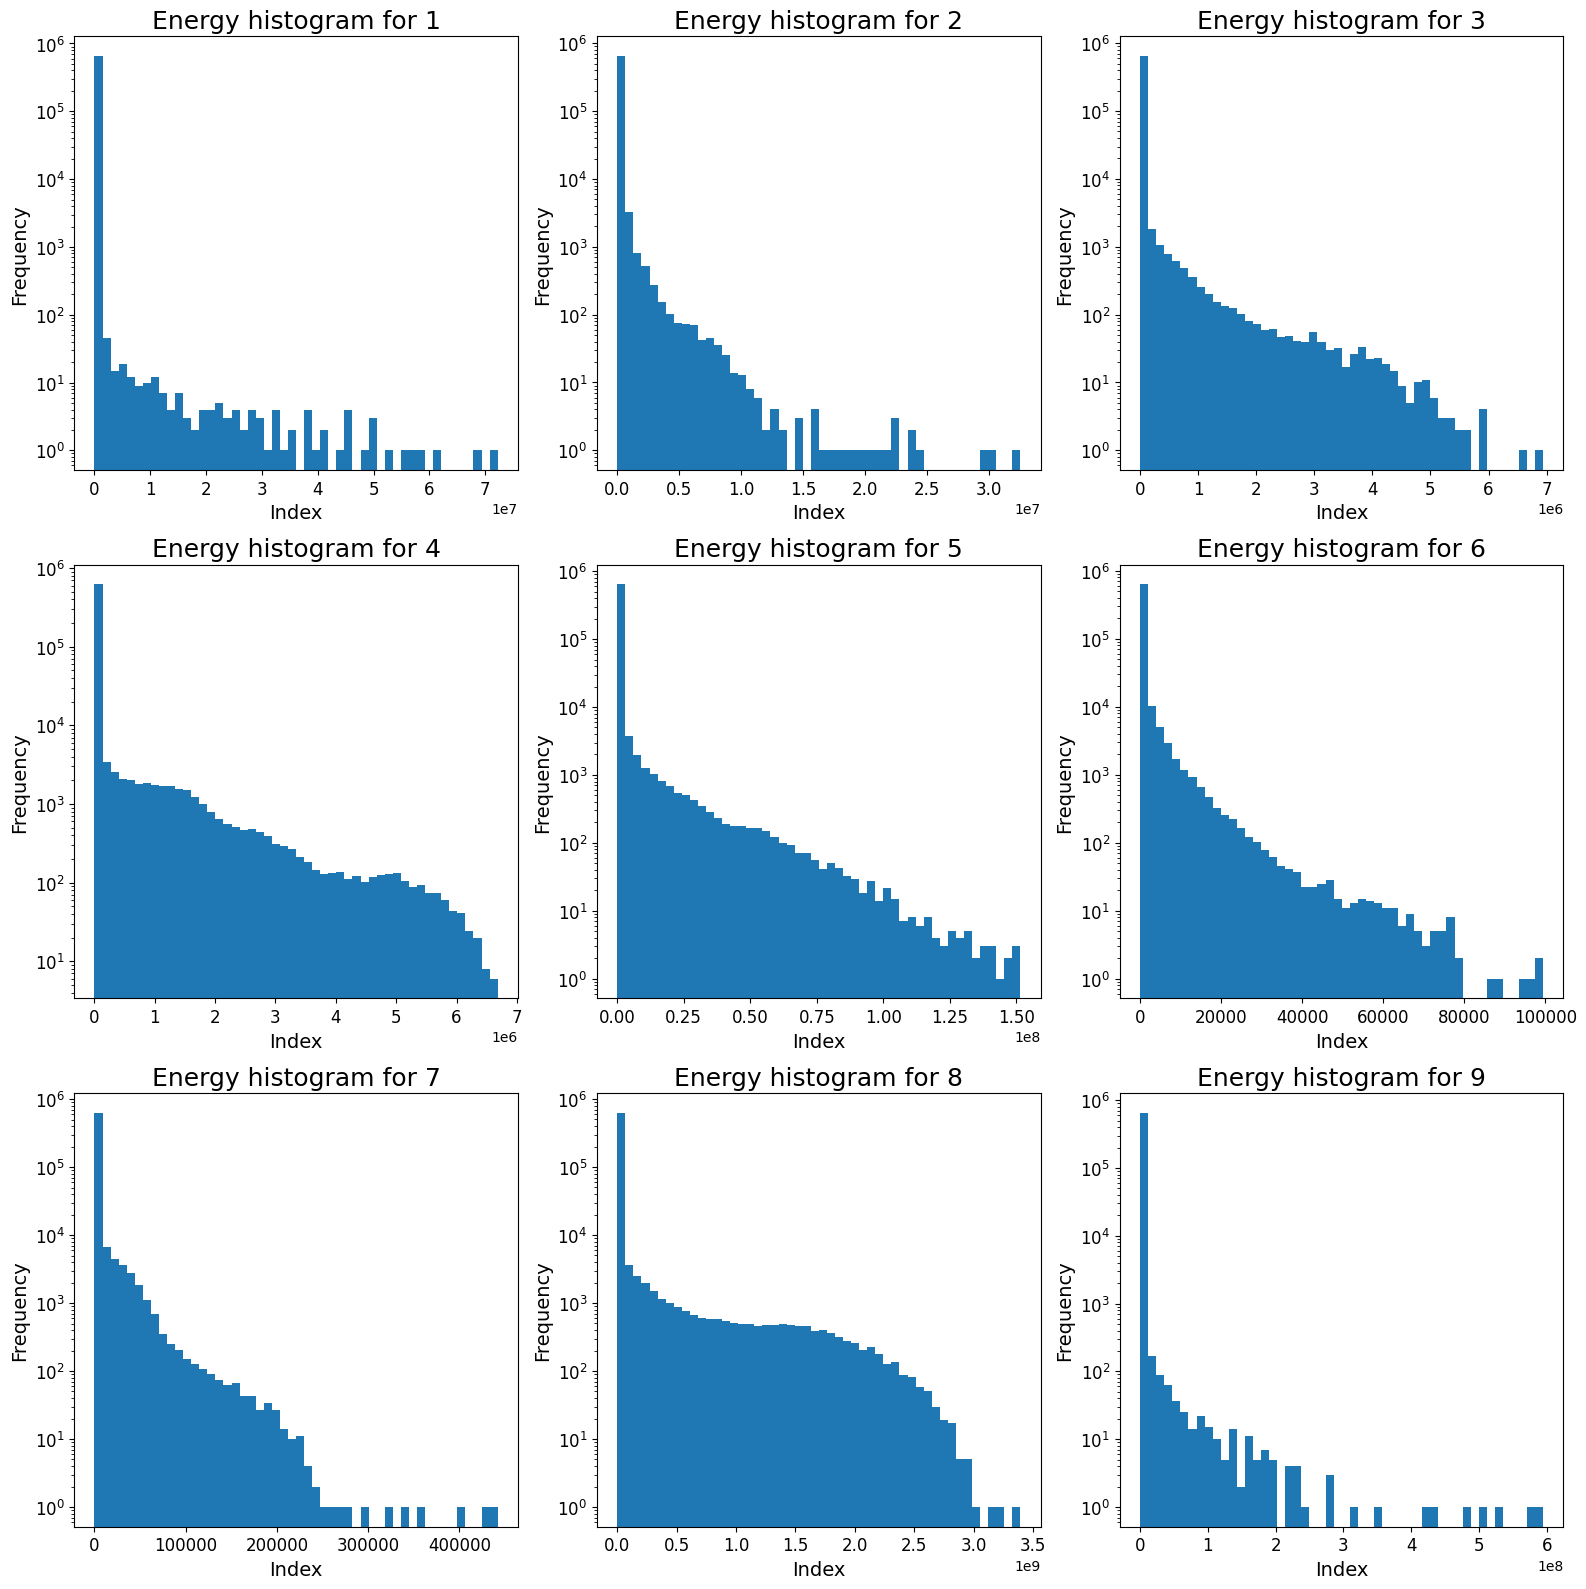

Bin width for 1: 41813.335
Bin width for 2: 4661731.52
Bin width for 3: 38760.63
Bin width for 4: 190763.94
Bin width for 5: 699360.96
Bin width for 6: 41.8346044921875
Bin width for 7: 75165.14
Bin width for 8: 4739.0875
Bin width for 9: 1210297.52


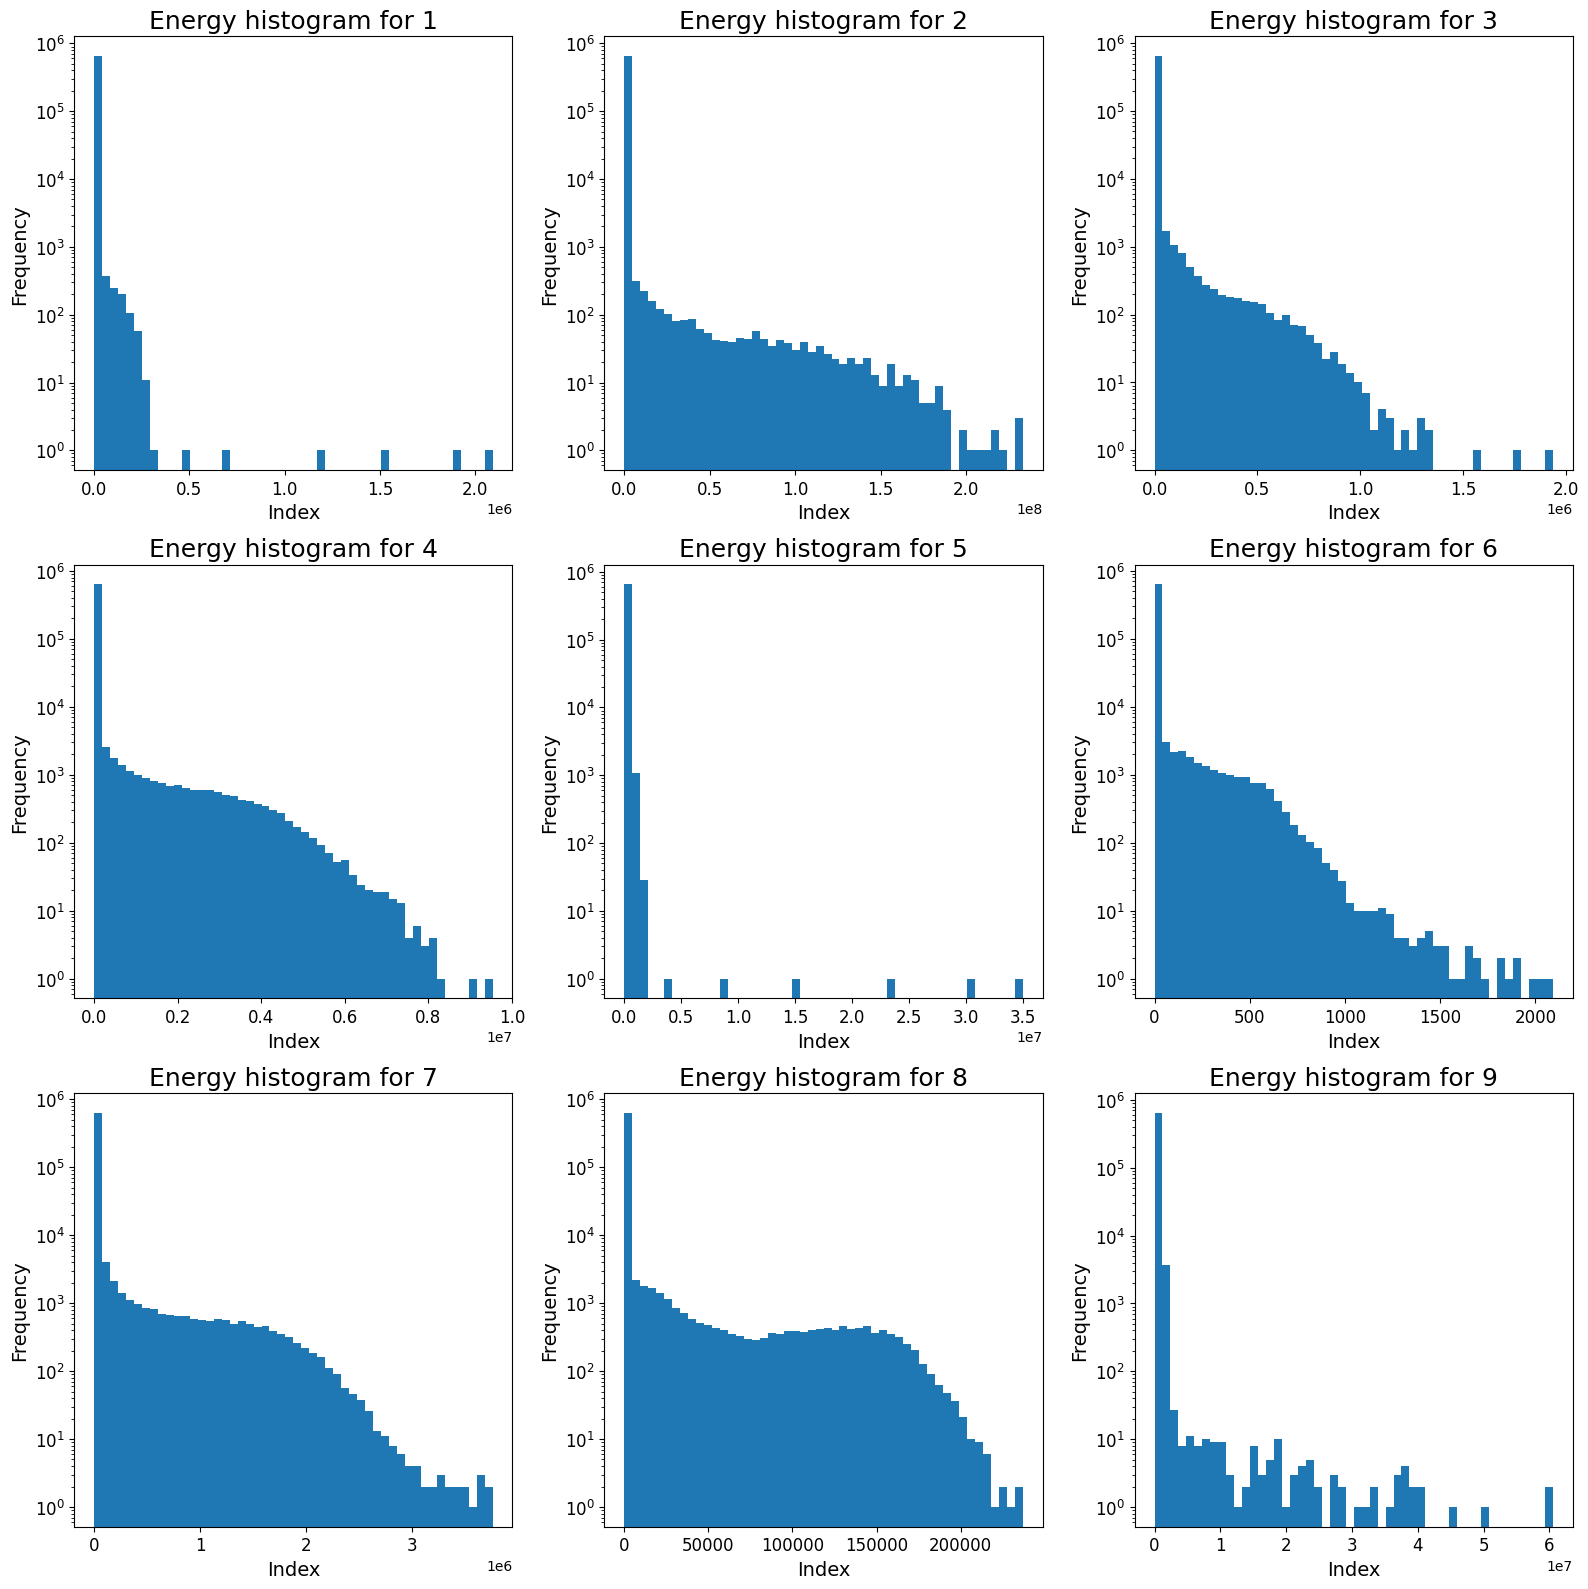

In [8]:
limits_lin = plot_energies_histogram_and_get_bin_width(temporal_energies_lin)
limits_co = plot_energies_histogram_and_get_bin_width(temporal_energies_co)

## Calculate the averages of both energy arrays

In [9]:
def get_energy_means(temporal_energies : dict) -> list:
    """
    Calculate the mean energy for each set of temporal energies.
    Args:
        temporal_energies (dict): A dictionary where the keys are identifiers and the values are arrays or lists of energy values.
    Returns:
        list: A list of mean energy values, one for each set of temporal energies.
    """
    means = []
    for energies in temporal_energies.values():
        means.append(energies.mean())
        
    return means
    

# means_lin = get_energy_means(temporal_energies_lin)
# means_co = get_energy_means(temporal_energies_co)

# limits = []
# limits.append(41813.34)
# limits.append(4661732.48)
# limits.append(38760.6425)
# limits.append(190763.94)
# limits.append(699360.96)
# limits.append(41.8346044921875)
# limits.append(75165.14)
# limits.append(4739.0875)
# limits.append(1210297.52)

## Preparing for store results 

In [10]:
def build_tries(attempts : int, temporal_energies : dict) -> list:
    """
    Constructs a list of sequences initialized with zeros based on the given number of attempts and temporal energies.

    Args:
        attempts (int): The number of attempts or trials to create.
        temporal_energies (dict): A dictionary where the values are arrays representing temporal energies.

    Returns:
        list: A list of lists, where each inner list contains arrays of zeros with the same shape as the corresponding temporal energy arrays.
    """
    tries = []
    for _ in range(attempts):
        sequences = []
        for energy in temporal_energies.values():
            a = np.zeros(energy.shape[0])
            sequences.append(a)
        tries.append(sequences)
    return tries

tries_lin = build_tries(attempts=10, temporal_energies=temporal_energies_lin)

tries_co = build_tries(attempts=10, temporal_energies=temporal_energies_co)

## Calculate the minimum length

In [11]:
def min_length(tries : list) -> int:
    """
    Determines the minimum length among the elements in a 2D list of arrays.

    Args:
        tries (list of list of np.ndarray): A 2D list where each element is a numpy array.

    Returns:
        int: The smallest length found among the arrays in the 2D list.
    """
    minimun = 100000000
    
    for i in range(len(tries)):
        for j in range(len(tries[0])):
            minimun = minimun if tries[i][j].shape[0] > minimun else tries[i][j].shape[0]
    return minimun

minimun = min(min_length(tries=tries_lin), min_length(tries=tries_co))
minimun

652848

## "The Algorithm"

In [12]:
def colin_sequence_by_energy(tries_lin : list, 
                            tries_co: list, 
                            temporal_energies_lin: dict, 
                            temporal_energies_co: dict, 
                            limits_lin: list, 
                            limits_co: list, 
                            minimun: int,
                            attempts: int,
                            destination_path_lin: str = None,
                            destination_path_co: str = None) -> tuple:
    """
    Executes the Colin sequence algorithm based on energy values for a specified number of attempts.
    
    Parameters:
    -----------
    tries_lin : list
        A list to store the lin-energy tries for each round.
    tries_co : list
        A list to store the co-energy tries for each round.
    temporal_energies_lin : dict
        A dictionary containing temporal lin-energy values.
    temporal_energies_co : dict
        A dictionary containing temporal co-energy values.
    limits_lin : list
        A list of limit values for lin-energies.
    limits_co : list
        A list of limit values for co-energies.
    minimun : int
        The minimum length to which energy arrays should be truncated.
    attempts : int
        The number of times the algorithm should be executed.
    destination_path_lin : str, optional
        The destination path to save the lin-energy tries. Defaults to None.
    destination_path_co : str, optional
        The destination path to save the co-energy tries. Defaults to None.
    
    Returns:
    --------
    tuple: tries_lin, tries_co with the stored results
    """
    
    audios_amount = len(limits_lin)
    
    # Number of times the algorithm should be executed
    for round in range(attempts):
        mask = np.full(audios_amount, False)
        energycopy_lin = []
        energycopy_co = []
        
        # Make copies of the energy arrays and truncate them to the same length
        for energy in temporal_energies_lin.values():
            listcopy = energy.copy()
            listcopy = listcopy[:minimun]
            energycopy_lin.append(listcopy)
        for energy in temporal_energies_co.values():
            listcopy = energy.copy()
            listcopy = listcopy[:minimun]
            energycopy_co.append(listcopy)
        
        # Iterate over the indices of the energy arrays, select the maximum from a random array,
        # copy that value, set it to 0 in the other arrays, and repeat
        for i in range(energycopy_lin[0].shape[0]):
            random = np.random.randint(0, 9)
            while mask[random]: 
                random = np.random.randint(0, 9)
            max_lin = energycopy_lin[random].max()
            argmax_lin = energycopy_lin[random].argmax()
            max_co = energycopy_co[random].max()
            argmax_co = energycopy_co[random].argmax()
            if max_lin > limits_lin[random] and max_co > limits_co[random]:
                tries_lin[round][random][argmax_lin] = max_lin
                tries_co[round][random][argmax_co] = max_co
            else:
                mask[random] = True
                if mask.all():
                    break
            for energy2 in energycopy_lin:
                energy2[argmax_lin] = 0
            for energy2 in energycopy_co:
                energy2[argmax_co] = 0
        
        # Save the tries data to a .npy file
        if destination_path_lin is None:
            destination_path_lin = f"{os.path.dirname(os.path.abspath(__file__))}/tries_lin"
        if destination_path_co is None:
            destination_path_co = f"{os.path.dirname(os.path.abspath(__file__))}/tries_co"
            
        for j in range(audios_amount):
            # Check if the directory exists, if not, create it
            if not os.path.exists(f'{destination_path_lin}/{round+1}'):
                os.makedirs(f'{destination_path_lin}/{round+1}')
            np.save(f'{destination_path_lin}/{round+1}/microphone{j+1}.npy', tries_lin[round][j])
            if not os.path.exists(f'{destination_path_co}/{round+1}'):
                os.makedirs(f'{destination_path_co}/{round+1}')
            np.save(f'{destination_path_co}/{round+1}/microphone{j+1}.npy', tries_co[round][j])
            
    return tries_lin, tries_co


In [13]:
destination_path_lin = f'../outputs/energy/tries_lin'
destination_path_co = f'../outputs/energy/tries_co'


tries_lin, tries_co = colin_sequence_by_energy(tries_lin=tries_lin,
                         tries_co=tries_co,
                         temporal_energies_lin=temporal_energies_lin,
                         temporal_energies_co=temporal_energies_co,
                         limits_lin=limits_lin,
                         limits_co=limits_co,
                         minimun=minimun,
                         attempts=10,
                         destination_path_lin=destination_path_lin,
                         destination_path_co=destination_path_co)

In [18]:
def plot_sequences(tries_lin : list, 
                   tries_co : list, 
                   hop_length : int, 
                   sample_rate : int, 
                   attempts : int, 
                   xlim_left : int = -1, 
                   xlim_right : int = -1) -> None:
    """
    Plots sequences of linear and co energy values over time for multiple attempts.
    
    Parameters:
    - tries_lin (list): A list of lists containing lin-energy values for each attempt.
    - tries_co (list): A list of lists containing co energy values for each attempt.
    - hop_length (int): The hop length used in the audio processing.
    - sample_rate (int): The sample rate of the audio.
    - attempts (int): The number of attempts to plot.
    - xlim_left (int, optional): The left limit for the x-axis. Defaults to -1 (no limit).
    - xlim_right (int, optional): The right limit for the x-axis. Defaults to -1 (no limit).
    
    Returns:
    - None: This function does not return any value. It displays the plots.
    
    The function creates a figure with two subplots, one for lin-energy values and one for co energy values.
    It plots the non-zero values of energy over time for each attempt, using different colors for each sequence.
    The y-axis is set to a logarithmic scale, and the x-axis represents time in seconds.
    """

    
    time_interval = hop_length / sample_rate

    for k in range(attempts):
        arrays_lin = tries_lin[k]
        arrays_co = tries_co[k]

        # colors = plt.cm.get_cmap('tab10', 9).colors
        colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'purple', 'orange']


        # Create a figure with 2 subplots
        _, axs = plt.subplots(2, 1, figsize=(10, 10))

        # Iterate over the arrays and plot non-zero values
        for i, (array_lin, array_co) in enumerate(zip(arrays_lin, arrays_co)):
            non_zero_indexes_lin = np.where(array_lin > 0)[0]
            non_zero_values_lin = array_lin[non_zero_indexes_lin]

            non_zero_indexes_co = np.where(array_co > 0)[0]
            non_zero_values_co = array_co[non_zero_indexes_co]

            # Convert indexes to milliseconds
            milliseconds_lin = non_zero_indexes_lin * time_interval
            milliseconds_co = non_zero_indexes_co * time_interval

            axs[0].scatter(milliseconds_lin, non_zero_values_lin, color=colors[i], label=f'Frog {i+1}')
            axs[1].scatter(milliseconds_co, non_zero_values_co, color=colors[i], label=f'Frog {i+1}')

        axs[0].set_title('lin', fontsize=14)
        axs[1].set_title('co', fontsize=14)

        # Configure the plots
        for ax in axs:
            ax.set_yscale('log')
            ax.set_xlabel('Time (s)', fontsize=12)
            ax.set_ylabel('Energy', fontsize=14)
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
            ax.tick_params(axis='both', which='major', labelsize=12)  

            if xlim_left != -1 and xlim_right == -1:
                ax.set_xlim(xlim_left, )
            elif xlim_left != -1 and xlim_right != -1:
                ax.set_xlim(xlim_left, xlim_right)
            elif xlim_left == -1 and xlim_right != -1:
                ax.set_xlim(0, xlim_right)

        plt.suptitle('Sequence', fontsize=18)
        # Show the plots
        plt.show()


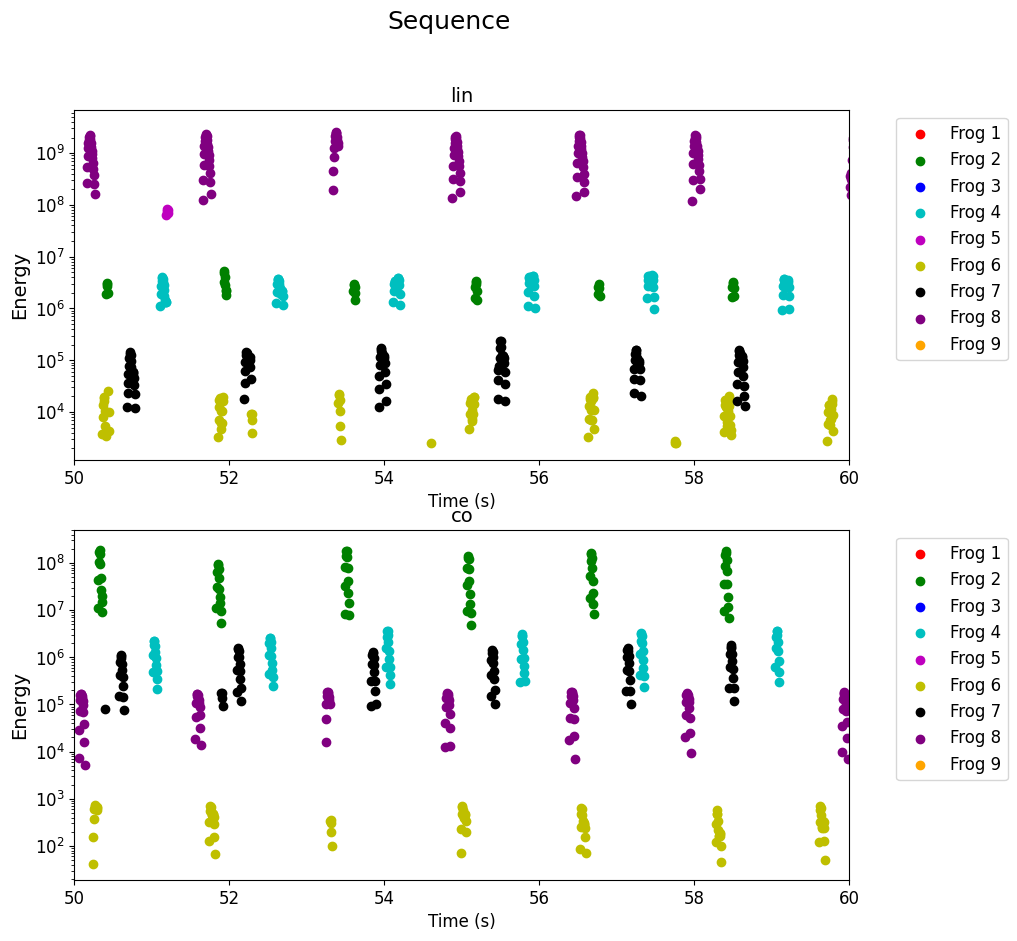

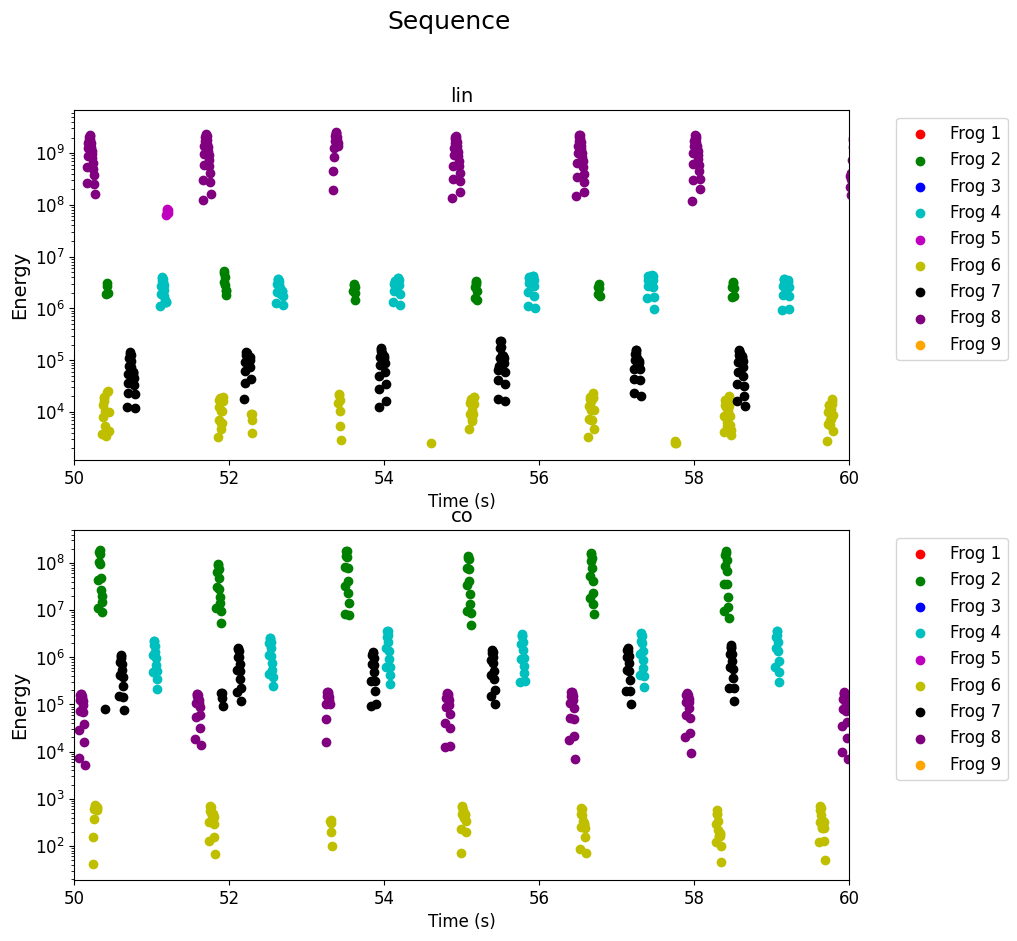

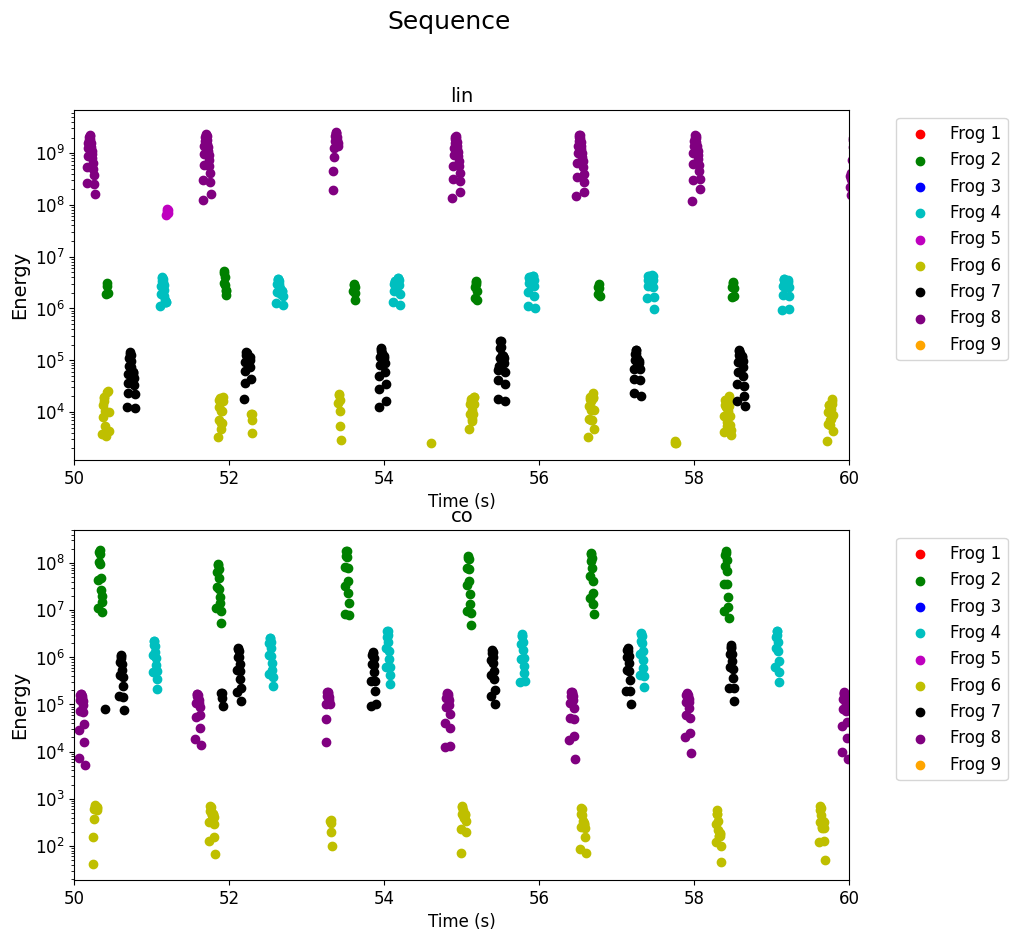

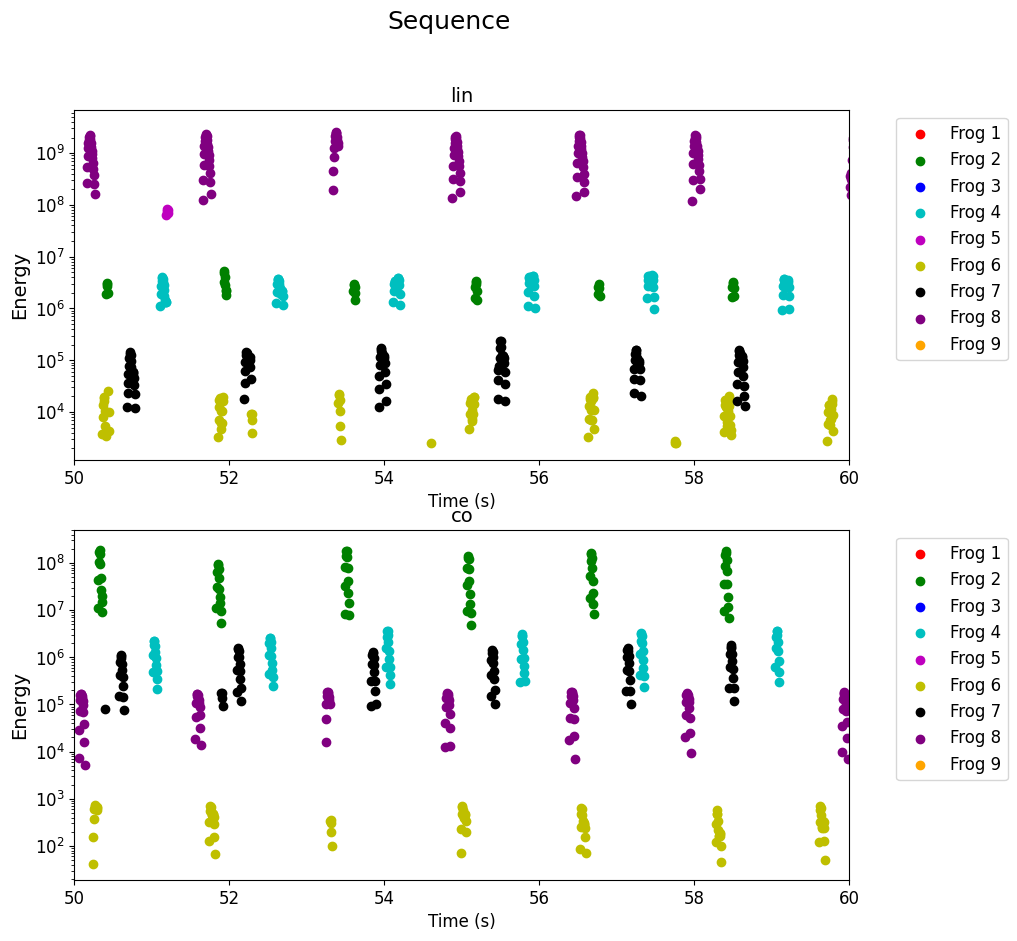

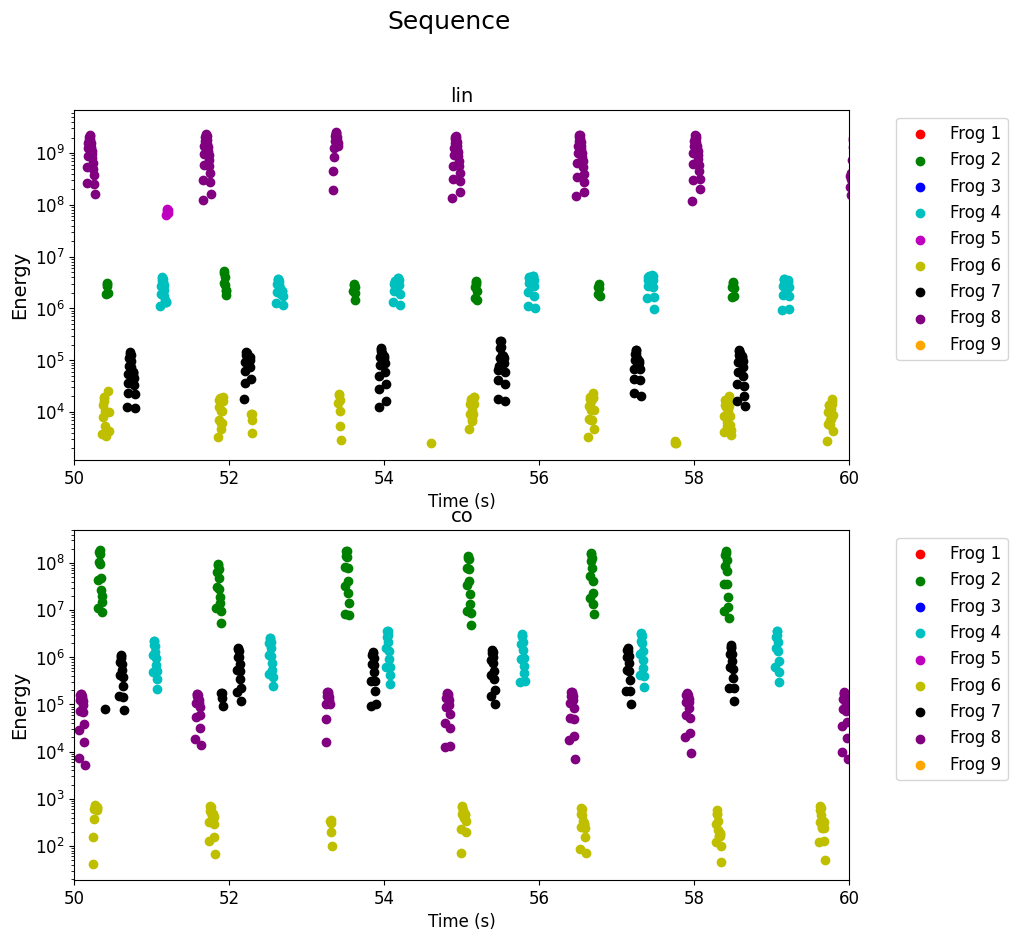

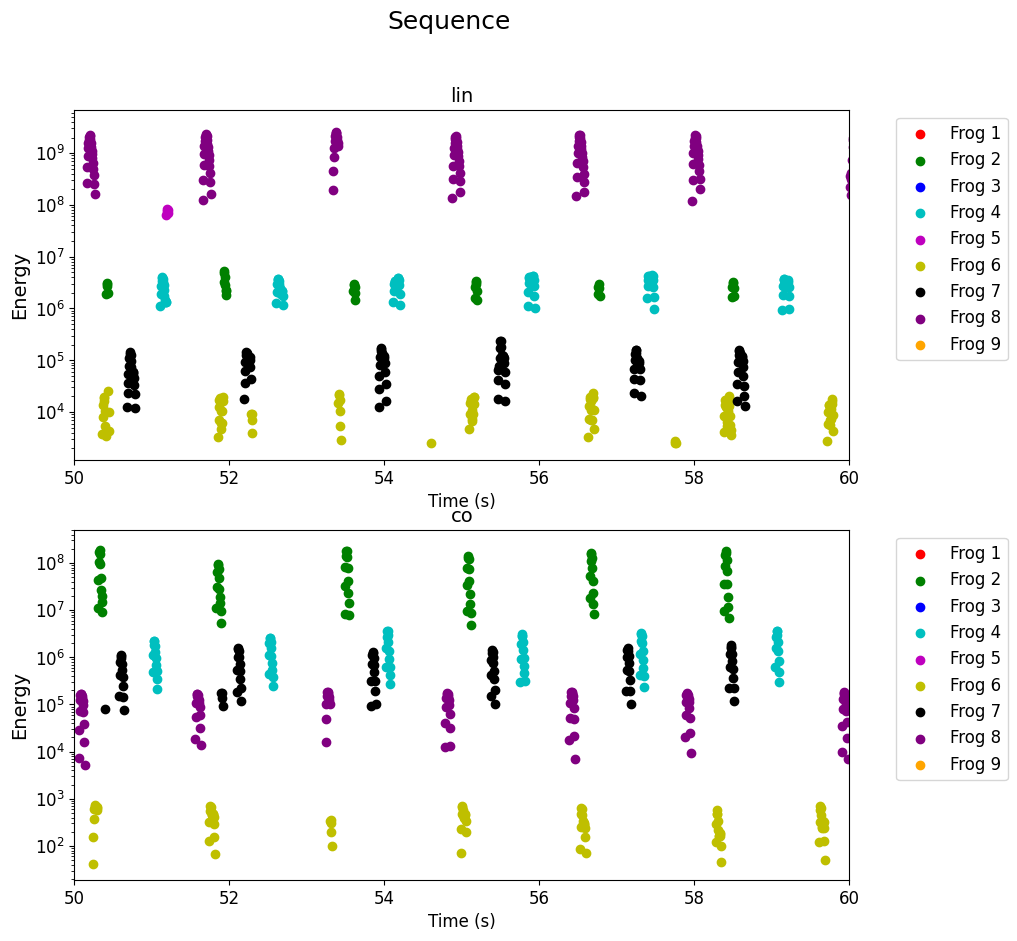

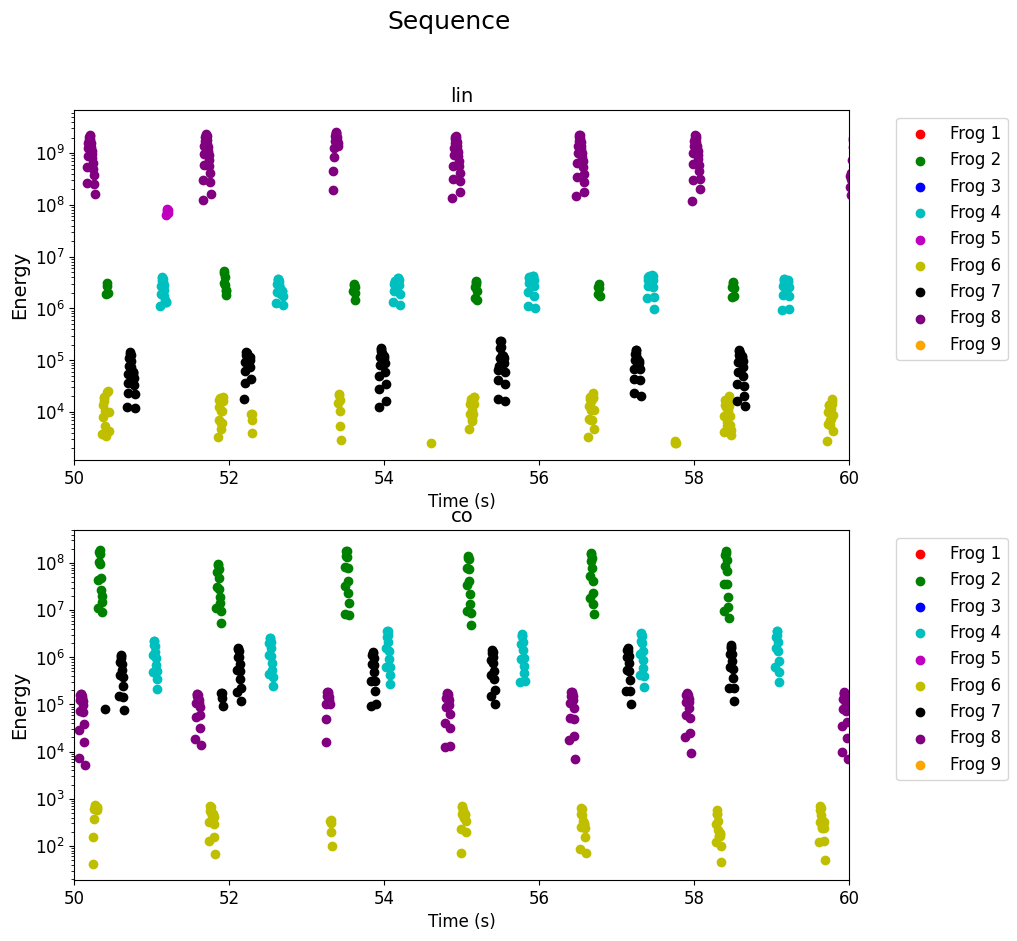

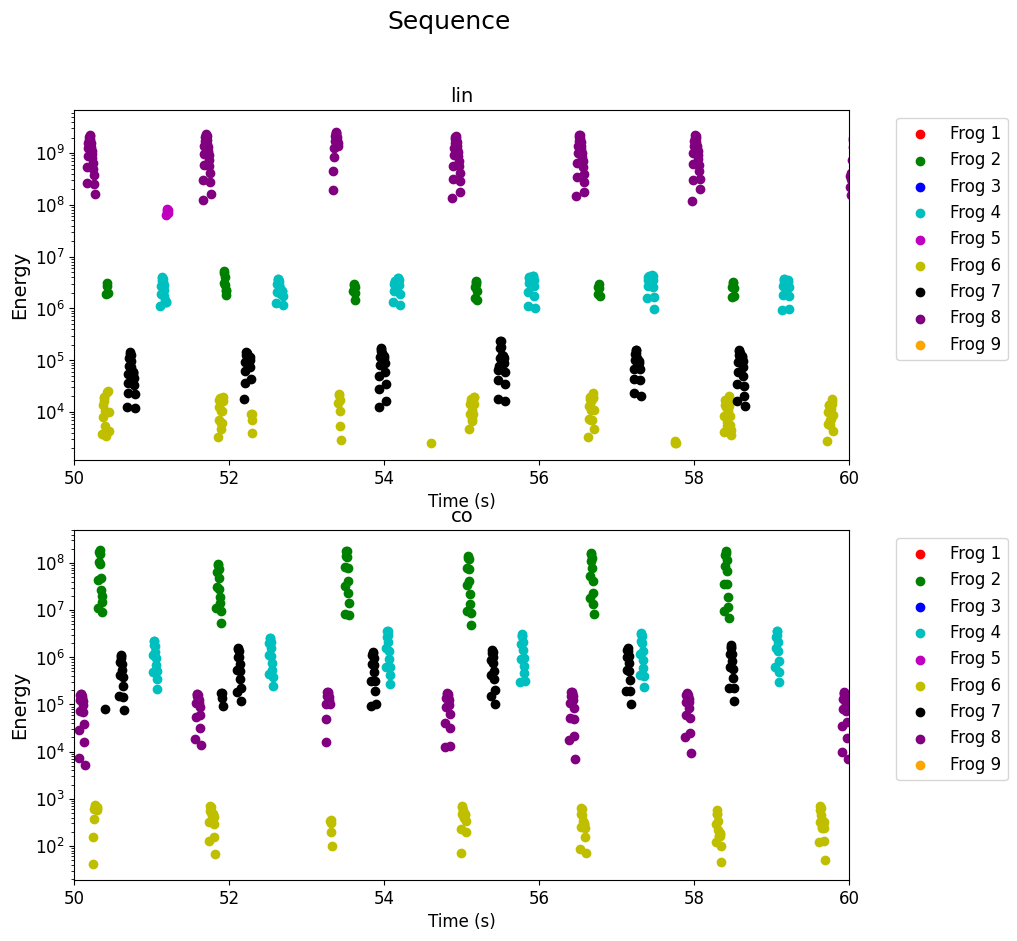

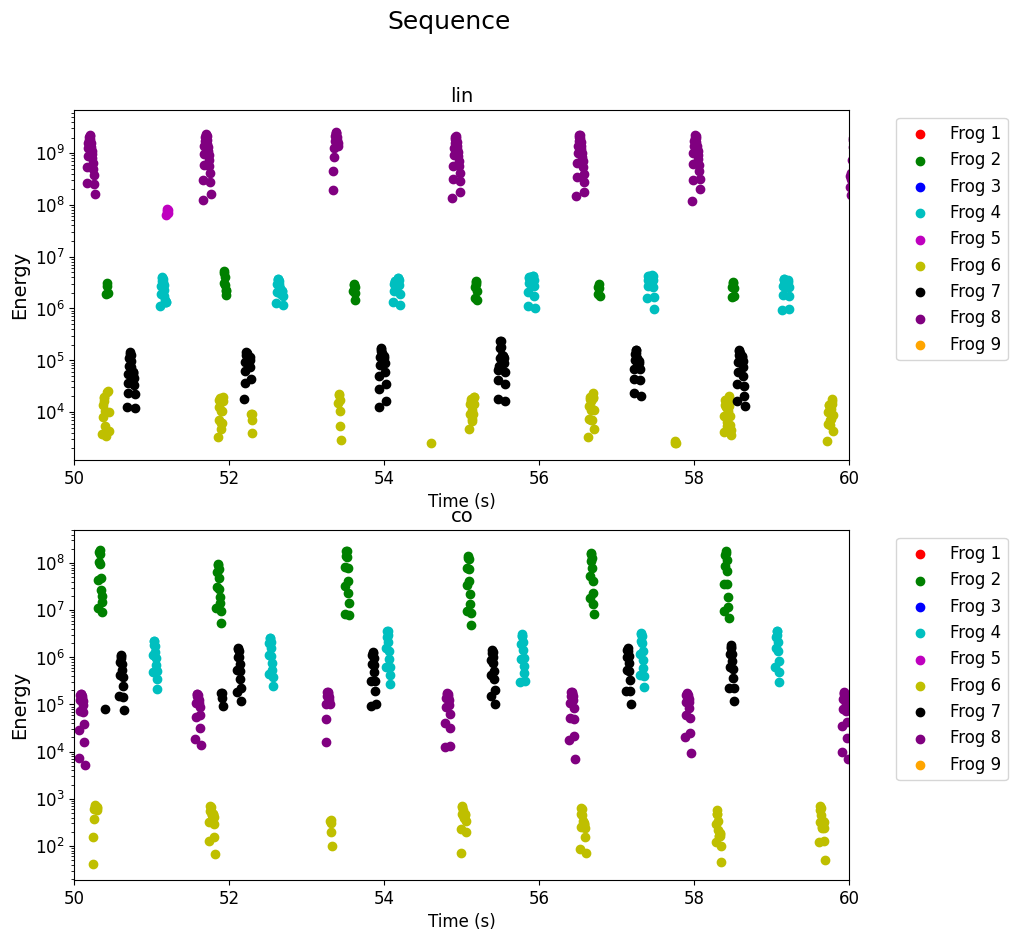

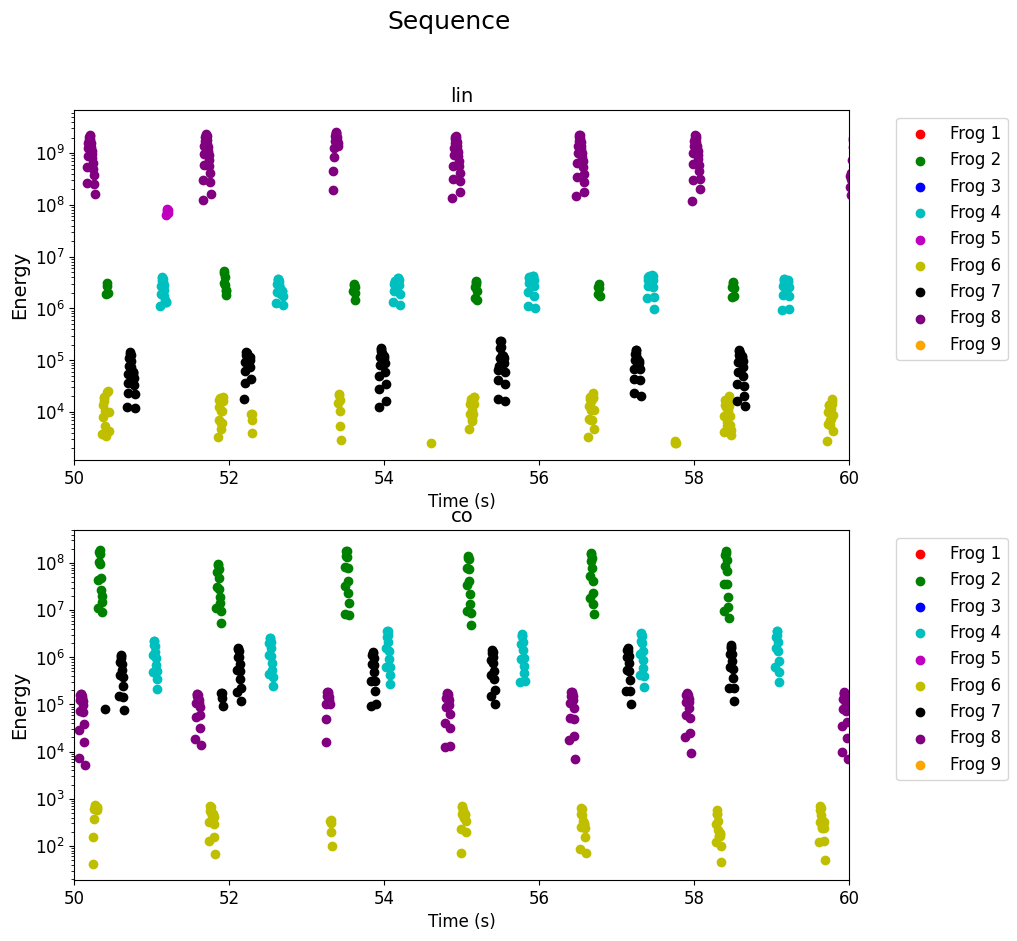

In [19]:
hop_length = 512
sample_rate = 96000

plot_sequences(tries_lin=tries_lin, 
               tries_co=tries_co, 
               hop_length=hop_length, 
               sample_rate=sample_rate, 
               attempts=10, 
               xlim_left=50, 
               xlim_right=60)

In [15]:
def get_sequency_pipeline(
    datapath: str,
    linpath: str = None,
    copath: str = None,
    destination_path_lin: str = None,
    destination_path_co: str = None,
    hop_length: int = -1,
    sample_rate: int = -1,
    plots: bool = True,
    verbose: bool = True,
    attempts: int = 10,
) -> None:
    """
    Processes the given data to generate and analyze sequences, dividing them into LIN and CO categories,
    calculating temporal energies, plotting histograms, and building tries.

    Parameters:
    - datapath (str): Path to the input data.
    - linpath (str, optional): Path to the LIN data. Defaults to None.
    - copath (str, optional): Path to the CO data. Defaults to None.
    - destination_path_lin (str, optional): Path to save the LIN results. Defaults to None.
    - destination_path_co (str, optional): Path to save the CO results. Defaults to None.
    - hop_length (int, optional): Hop length for plotting sequences. Defaults to -1.
    - sample_rate (int, optional): Sample rate for plotting sequences. Defaults to -1.
    - plots (bool, optional): Whether to plot the sequences. Defaults to True.
    - verbose (bool, optional): Whether to print verbose output. Defaults to True.
    - attempts (int, optional): The number of times the algorithm should be executed.

    Returns:
    None
    """

    if verbose:
        print(
            "---------------------------DIVIDING INTO LIN AND CO--------------------------"
        )
    linpath, copath = divide_into_lin_co(
        datapath=datapath, linpath=linpath, copath=copath
    )

    if verbose:
        print(
            "---------------------------CALCULATING TEMPORAL ENERGIES FOR LIN--------------------------"
        )
    temporal_energies_lin = get_temporal_energies(linpath)

    if verbose:
        print(
            "---------------------------CALCULATING TEMPORAL ENERGIES FOR CO--------------------------"
        )
    temporal_energies_co = get_temporal_energies(copath)

    if verbose:
        print(
            "---------------------------PLOTTING HISTOGRAMS AND GETTING BIN WIDTHS FOR LIN--------------------------"
        )
    limits_lin = plot_energies_histogram_and_get_bin_width(temporal_energies_lin)

    if verbose:
        print(
            "---------------------------PLOTTING HISTOGRAMS AND GETTING BIN WIDTHS FOR CO--------------------------"
        )
    limits_co = plot_energies_histogram_and_get_bin_width(temporal_energies_co)

    # if verbose:
    #     print(
    #         "---------------------------CALCULATING ENERGY MEANS FOR LIN--------------------------"
    #     )
    # means_lin = get_energy_means(temporal_energies_lin)

    # if verbose:
    #     print(
    #         "---------------------------CALCULATING ENERGY MEANS FOR CO--------------------------"
    #     )
    # means_co = get_energy_means(temporal_energies_co)

    if verbose:
        print(
            "---------------------------BUILDING TRIES FOR LIN--------------------------"
        )
    tries_lin = build_tries(attempts=attempts, temporal_energies=temporal_energies_lin)

    if verbose:
        print(
            "---------------------------BUILDING TRIES FOR CO--------------------------"
        )
    tries_co = build_tries(attempts=attempts, temporal_energies=temporal_energies_co)

    if verbose:
        print(
            "---------------------------CALCULATING MINIMUN LENGTH--------------------------"
        )
    minimun = min(min_length(tries=tries_lin), min_length(tries=tries_co))

    if verbose:
        print(
            "---------------------------GETTING COLIN SEQUENCE BY ENERGY--------------------------"
        )
    tries_lin, tries_co = colin_sequence_by_energy(
        tries_lin=tries_lin,
        tries_co=tries_co,
        temporal_energies_lin=temporal_energies_lin,
        temporal_energies_co=temporal_energies_co,
        limits_lin=limits_lin,
        limits_co=limits_co,
        minimun=minimun,
        attempts=attempts,
        destination_path_lin=destination_path_lin,
        destination_path_co=destination_path_co,
    )

    if plots:
        if verbose:
            print(
                "---------------------------PLOTTING SEQUENCES--------------------------"
            )
        plot_sequences(
            tries_lin=tries_lin,
            tries_co=tries_co,
            hop_length=hop_length,
            sample_rate=sample_rate,
            attempts=attempts,
            xlim_left=50,
            xlim_right=60,
        )

In [1]:
datapath = '../data/aligned/all'
linpath = '../data/aligned/lin'
copath = '../data/aligned/co'


destination_path_lin = f'../outputs/energy/tries_lin'
destination_path_co = f'../outputs/energy/tries_co'

hop_length = 512
sample_rate = 96000

get_sequency_pipeline(
    datapath=datapath,
    linpath=linpath,
    copath=copath,
    destination_path_lin=destination_path_lin,
    destination_path_co=destination_path_co,
    hop_length=hop_length,
    sample_rate=sample_rate,
    plots=True,
    verbose=True,
    attempts=10,
)